In [1]:
import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
## load data
path = '/gpfs/commons/groups/knowles_lab/data/ADSP_reguloML/ADSP_vcf/58K_preview/phenotype/'
ADNI = pd.read_csv(path + "ADNIPhenotypes_DS_2024.11.22_ALL.csv")
family_based = pd.read_csv(path + "ADSPFamilyBasedPhenotypes_DS_2024.11.22_ALL.csv")
case_control = pd.read_csv(path + "ADSPCaseControlPhenotypes_DS_2024.11.22_ALL.csv")

SUBJ_drop = pd.read_excel('/gpfs/commons/groups/knowles_lab/data/ADSP_reguloML/ADSP_vcf/phenotype_file/release_36K/ng00067_subject_droplist_2022.08.18.xlsx', engine = 'openpyxl')## old drop list
manifest = pd.read_csv(path + "SampleManifest_DS_2024.11.22_ALL.csv") ## the one with mapping info

qc = pd.read_csv(path+"gcad.r5.wgs.58507.2024.11.03.quality.metrics.ALL.csv") ## this one contains QC info( all the sampleID here are WGS)

/gpfs/commons/home/tlin/.conda/envs/polyfun/lib/python3.6/site-packages/IPython/core/interactiveshell.py:3072: DtypeWarning: Columns (36) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


## deal with pheno_merge

In [3]:
print(ADNI.shape, family_based.shape, case_control.shape)

(2168, 33) (42898, 29) (62764, 30)


### ADNI

In [4]:
## can directly use AD_last visit for Diagnosis
print(ADNI.AD_last_visit.value_counts())
print(ADNI[(ADNI.PrevAD == 1) | (ADNI.IncAD == 1)].shape)

0.0    1427
1.0     740
Name: AD_last_visit, dtype: int64
(740, 33)


In [5]:
# ADNI_column = ['SUBJID','Sex','Cohort','PrevAD','IncAD','AD_last_visit','Age_current','Age_baseline','Age_MCI_onset','Age_AD_onset','Comments', 'Duplicate_SUBJID', 'Flag',
#        'Latest_Update_Version', 'Base_PrevAD', 'Base_IncAD', 'Base_AUTOPSY', 'Base_Braak', 'Base_AD', 'Base_MCI', 'Base_Version','Correction']
#ADNI_processed = ADNI.loc[:,ADNI_column]
ADNI_processed = ADNI
ADNI_processed["Diagnosis"] = ADNI_processed.AD_last_visit

ADNI_processed["Age"] = ADNI_processed.Age_current
ADNI_processed.loc[ADNI_processed.Diagnosis == 1,'Age'] = ADNI_processed.loc[ADNI_processed.Diagnosis == 1,'Age_AD_onset']  ## changed the age to age of onset of they are AD cases


ADNI_processed.drop(['PrevAD','IncAD','AD_last_visit','Age_current','Age_baseline','Age_AD_onset','Age_MCI_onset'], axis=1, inplace=True)

print(ADNI_processed.value_counts('Diagnosis'))
ADNI_processed.shape

Diagnosis
0.0    1427
1.0     740
dtype: int64


(2168, 28)

In [6]:
## check NA
ADNI_processed[ADNI_processed.isnull()].sum()

SUBJID                   0.0
Cohort                   0.0
Sex                      0.0
APOE_reported            0.0
APOE_WGS                 0.0
AUTOPSY                  0.0
Braak                    0.0
Race                     0.0
Ethnicity                0.0
MCI_last_visit           0.0
Comments                 0.0
Duplicate_SUBJID         0.0
Flag                     0.0
Latest_Update_Version    0.0
Base_PrevAD              0.0
Base_IncAD               0.0
Base_Age                 0.0
Base_AUTOPSY             0.0
Base_Braak               0.0
Base_AD                  0.0
Base_MCI                 0.0
Base_Version             0.0
Update_Baseline          0.0
Update_Latest            0.0
Update_Diagnosis         0.0
Correction               0.0
Diagnosis                0.0
Age                      0.0
dtype: float64

### family_based

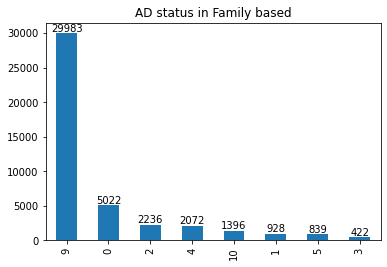

In [7]:
ax = family_based.AD.value_counts().plot(kind='bar', ylabel='', title='AD status in Family based')
for p in ax.patches:
    ax.annotate(str(p.get_height()), (p.get_x() + p.get_width() / 2, p.get_height()), ha='center', va='bottom')

plt.show()

In [8]:
family_based['Diagnosis'] = np.nan
family_based.loc[(family_based['AD'] >=1) & (family_based['AD'] <=3), "Diagnosis"] =1
family_based.loc[ family_based['AD'] == 0 , "Diagnosis"] =0
#family_based.loc[family_based['AD'] != 1, "Diagnosis"] = 0
family_based.Diagnosis.value_counts(dropna=False)

NaN    34290
0.0     5022
1.0     3586
Name: Diagnosis, dtype: int64

### case_control

In [9]:
## here we use AD as AD diagnosis
print(case_control.AD.value_counts())
print(case_control[(case_control.PrevAD == 1) | (case_control.IncAD == 1)].shape)

0.0    33970
1.0    16890
Name: AD, dtype: int64
(16890, 30)


In [10]:
case_control.AD = case_control.AD.astype('Int64')
case_control_processed = case_control.rename(columns = {'AD':'Diagnosis'})
print(case_control_processed.Diagnosis.value_counts(dropna=False))

0      33970
1      16890
NaN    11904
Name: Diagnosis, dtype: Int64


In [10]:
## na are from a variety of diseases

na = case_control[case_control.AD.isna()]
comment_counts = na.Comments.value_counts()
#comment_counts[comment_counts > 10]
case_control[case_control.AD.isna()].Comments.unique()

array(['ng00067.v2 - Case converted to Other Dementia',
       'ng00067.v3 - Braak corrected, ng00067.v2 - Case converted to Other Dementia',
       'ng00067.v2 - Control converted to Other Dementia',
       'ng00067.v9 - Diagnosis: [Dementia]',
       'ng00067.v9 - Diagnosis: [MCI]', 'ng00067.v9 - Diagnosis: [CIND]',
       'ng00067.v9 - Diagnosis: [Cognitive Impairment not AD]',
       'ng00067.v9 - Diagnosis: [Cognitively Impaired]',
       'ng00067.v9 - Diagnosis: [Other]',
       'ng00067.v9 - Diagnosis: [Stroke]',
       'ng00067.v9 - Diagnosis: [Borderline]',
       'ng00067.v9 - Diagnosis: [Impaired by 3MS<=87]',
       'ng00067.v9 - Diagnosis: [Unclear]',
       'ng00067.v9 - Diagnosis: [Affected by Exam]',
       'ng00067.v9 - Diagnosis: [CI]', 'ng00067.v9 - Diagnosis: [CDX NA]',
       nan, 'ng00067.v9 - Diagnosis: [Cog Imp secondary to Vascular]',
       'ng00067.v14 - Diagnosis: [MCI]',
       'ng00067.v2 - Case Converted to Control, exclude from analyses',
       'ng00067

In [11]:
na.Comments.value_counts()

ng00067.v14 - Diagnosis: no clinical diagnosis, see PHC neuropath phenotypes                                          2100
ng00067.v14 - Diagnosis: [MCI]                                                                                        1638
ng00067.v9 - Diagnosis: [MCI]                                                                                          720
ng00067.v14 - Diagnosis: [Vascular brain injury or vascular dementia including stroke]                                 292
ng00067.v14 - Diagnosis: [Lewy body disease (LbD)]                                                                     201
                                                                                                                      ... 
ng00067.v14 - Diagnosis: [Depression/Anxiety, HRT, GERD, Osteoarthritis, Hypertension]                                   1
ng00067.v14 - Diagnosis: [MCI Non-amnestic disorder focal + other domains with subcortical white matter lucencies]       1
ng00067.v14 - Di

In [11]:
## total count of each pheno file before merging
print(ADNI_processed.shape)
print(family_based.shape)
print(case_control_processed.shape)

(2168, 28)
(42898, 30)
(62764, 30)


### merge

In [12]:
ADNI_processed["source"] = 'ADNI'
family_based["source"] = 'family_based'
case_control_processed["source"] = 'case_control'

pheno = pd.concat([ADNI_processed, family_based, case_control_processed])
pheno.loc[pheno['Age'] == '90+', 'Age'] = 90
pheno.loc[pheno['Age_baseline'] == '90+', 'Age_baseline'] = 90
#pheno.Age = pheno.Age.astype('int') ## because there're NA
print(pheno.shape)
pheno.Diagnosis.value_counts(dropna=False)

(107830, 39)


NaN    46195
0.0    40419
1.0    21216
Name: Diagnosis, dtype: int64

In [13]:
## Only keep WGS (making sure this two way of extraction gives the same output)
print(qc[qc['WGS.WES'] == 'WGS'].SampleID.shape) 
print(manifest[manifest.SAMPLE_USE =='WGS'].shape)

wgs_SUBJID = manifest[manifest.SAMPLE_USE =='WGS'].SUBJID
print(wgs_SUBJID.shape)

print('before extracting WGS', pheno.shape)
pheno = pheno[pheno.SUBJID.isin(wgs_SUBJID)]

print('After extracting WGS', pheno.shape)

(58507,)
(58507, 10)
(58507,)
before extracting WGS (107830, 39)
After extracting WGS (55539, 39)


In [14]:
## drop technique replicates (using SUBJID)
replicate_to_drop = manifest[(manifest.Technical_Replicate == 1)] ## 101 rows
print(pheno[pheno.SUBJID.isin(replicate_to_drop.SUBJID)].shape) ## non of the rows in pheno are technical replicate

pheno.shape

(6, 39)


(55539, 39)

### handle duplicated SUBJID

In [15]:
## There are 199 pairs of duplicates (from family_based and case_control)
duplicated_ID = pheno[pheno.SUBJID.duplicated()].SUBJID
print(pheno[pheno.SUBJID.isin(duplicated_ID)].value_counts('source'))

source
family_based    199
case_control    199
dtype: int64


In [16]:
duplicated_id = pheno[pheno.SUBJID.isin(duplicated_ID)].sort_values(['SUBJID','source'])[['SUBJID', 'source','Diagnosis','Age']]

# Find SUBJID groups where Age or Diagnosis are different
different_groups = (
    duplicated_id.groupby(['SUBJID'])
     .filter(lambda x: x['Age'].nunique(dropna=False) > 1 or x['Diagnosis'].nunique(dropna=False) > 1)
)
different_groups

,SUBJID,source,Diagnosis,Age
2667,A-CUHS-CU000169,case_control,<NA>,86
2683,A-CUHS-CU000169,family_based,NaN,86
2672,A-CUHS-CU001191,case_control,<NA>,NaN
37553,A-CUHS-CU001191,family_based,NaN,NaN
2707,A-CUHS-CU003309,case_control,<NA>,73
37376,A-CUHS-CU003309,family_based,NaN,73
2762,A-CUHS-CU003369,case_control,<NA>,67
38331,A-CUHS-CU003369,family_based,NaN,67
2776,A-CUHS-CU003384,case_control,<NA>,NaN
37768,A-CUHS-CU003384,family_based,NaN,NaN


#### (1) when they shared the same Diagnosis & age, keep the ones from Family_based

In [17]:
duplicated_id[(~duplicated_id.SUBJID.isin(different_groups.SUBJID)) & (duplicated_id.source == 'case_control')] ## these 183 rows should be removed
to_remove = duplicated_id[(~duplicated_id.SUBJID.isin(different_groups.SUBJID)) & (duplicated_id.source == 'case_control')].SUBJID
len(to_remove)

183

In [20]:
pheno = pheno[~((pheno.SUBJID.isin(to_remove)) & (pheno.source == 'case_control'))]
duplicated_ID = duplicated_ID[~duplicated_ID.isin(to_remove)] ## 16 left

#### (2) when one of them have NAs in Diagnosis or Age, keep the other one with no NAs

In [21]:
# Filter rows where SUBJID is in duplicated_ID
filtered = pheno[pheno.SUBJID.isin(duplicated_ID)]

# Sort by SUBJID and source for consistent grouping
sorted_filtered = filtered.sort_values(['SUBJID', 'source'])[['SUBJID', 'source', 'Diagnosis', 'Age']]
sorted_filtered  ## there's only one row that need to be kept (A-LOAD-LD000442, case_control)

,SUBJID,source,Diagnosis,Age
2667,A-CUHS-CU000169,case_control,<NA>,86
2683,A-CUHS-CU000169,family_based,NaN,86
2672,A-CUHS-CU001191,case_control,<NA>,NaN
37553,A-CUHS-CU001191,family_based,NaN,NaN
2707,A-CUHS-CU003309,case_control,<NA>,73
37376,A-CUHS-CU003309,family_based,NaN,73
2762,A-CUHS-CU003369,case_control,<NA>,67
38331,A-CUHS-CU003369,family_based,NaN,67
2776,A-CUHS-CU003384,case_control,<NA>,NaN
37768,A-CUHS-CU003384,family_based,NaN,NaN


In [26]:
## Single the one to keep out
kept = pheno[(pheno.SUBJID == 'A-LOAD-LD000442') & (pheno.source == 'case_control')]

## remove everything else
remove = sorted_filtered.SUBJID
pheno = pheno[~pheno.SUBJID.isin(remove)]
pheno = pd.concat([pheno, kept])
pheno.shape

(55325, 39)

### final check phenotype, with Update_ADstatus

In [27]:
pheno.columns

Index(['SUBJID', 'Cohort', 'Sex', 'APOE_reported', 'APOE_WGS', 'AUTOPSY',
       'Braak', 'Race', 'Ethnicity', 'MCI_last_visit', 'Comments',
       'Duplicate_SUBJID', 'Flag', 'Latest_Update_Version', 'Base_PrevAD',
       'Base_IncAD', 'Base_Age', 'Base_AUTOPSY', 'Base_Braak', 'Base_AD',
       'Base_MCI', 'Base_Version', 'Update_Baseline', 'Update_Latest',
       'Update_Diagnosis', 'Correction', 'Diagnosis', 'Age', 'source', 'FamID',
       'Father', 'Mother', 'AD', 'Age_baseline', 'FamGrp', 'Update_ADstatus',
       'PrevAD', 'IncAD', 'Selection'],
      dtype='object')

In [28]:
pheno.loc[pheno.Diagnosis.isna(),['AD','source','Update_ADstatus','Diagnosis']]

,AD,source,Update_ADstatus,Diagnosis
1620,NaN,ADNI,NaN,NaN
0,9.0,family_based,1.0,NaN
2,5.0,family_based,1.0,NaN
5,5.0,family_based,1.0,NaN
22,5.0,family_based,1.0,NaN
...,...,...,...,...
62756,NaN,case_control,0.0,<NA>
62759,NaN,case_control,0.0,<NA>
62761,NaN,case_control,0.0,<NA>
62762,NaN,case_control,0.0,<NA>


In [29]:
pheno[(pheno.Diagnosis != 1) & (pheno.Update_ADstatus == 1)].Diagnosis.value_counts(dropna=False)

NaN    2908
0.0     753
Name: Diagnosis, dtype: int64

In [30]:
## change all of their Diagnosis to Case!
pheno.loc[(pheno.Diagnosis != 1) & (pheno.Update_ADstatus == 1),'Diagnosis'] = 1 
print(len(pheno.SUBJID.unique()))
print(pheno.Diagnosis.value_counts(dropna=False))
#pheno = pheno[["SUBJID", "Sex", "Diagnosis", "APOE_reported","Age","Race","Ethnicity","FamID",'source']]

55325
0.0    29337
1.0    18177
NaN     7811
Name: Diagnosis, dtype: int64


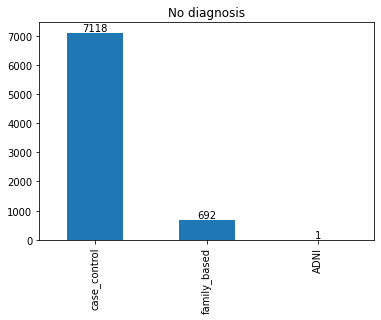

In [31]:
ax = pheno.loc[pheno.Diagnosis.isna()].source.value_counts().plot(kind='bar', ylabel='', title='No diagnosis')
for p in ax.patches:
    ax.annotate(str(p.get_height()), (p.get_x() + p.get_width() / 2, p.get_height()), ha='center', va='bottom')

In [32]:
count = pheno.source.value_counts()
count

case_control    49096
family_based     4061
ADNI             2168
Name: source, dtype: int64

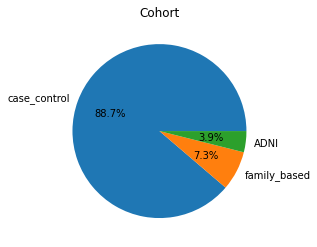

In [33]:
count.plot.pie(y=count, labels=count.index, autopct='%1.1f%%', title='Cohort',ylabel='')
plt.show()

In [34]:
pheno.to_csv(path+'pheno_merge.tsv', index = False, sep = '\t')

In [44]:
pheno.Diagnosis.value_counts(dropna=False)

0.0    29337
1.0    18177
NaN     7811
Name: Diagnosis, dtype: int64

In [35]:
## check the race count (only when Diagnosis exists)
pheno_no_na = pheno[~pheno.Diagnosis.isna()]
count_race = pheno_no_na.Race.value_counts(dropna=False)
count_race = count_race.rename(index={1.0: 'American Indian/Alaska Native', 2.0: 'Asian',3.0: 'Native Hawaiian or Other Pacific Islander',
                        4.0: 'Black or African American',5.0 :'White', 6.0:'Others'})

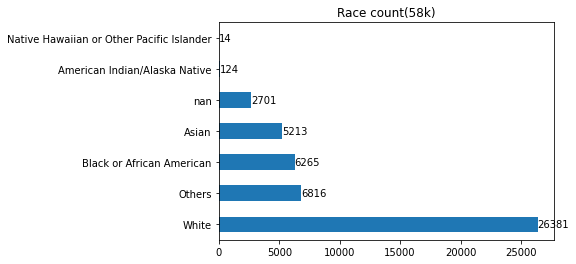

In [36]:
ax = count_race.plot(kind='barh', ylabel='', title='Race count(58k)')
for p in ax.patches:
    ax.annotate(
        str(p.get_width()),  # Use the width (count) for the annotation
        (p.get_x() + p.get_width() + 1, p.get_y() + p.get_height() / 2),  # Position slightly outside the bar
        ha='left',  # Horizontal alignment
        va='center'  # Vertical alignment
    )
# # Show the plot
# plt.show()

In [29]:
pheno.Ethnicity.value_counts(dropna=False)  # hispanic or not

0.0    37777
1.0    15382
NaN     2166
Name: Ethnicity, dtype: int64

## manifest & QC (merging SUBJID and SampleID)

In [63]:
pheno = pd.read_csv(path+'pheno_merge.tsv', sep = '\t')
manifest = pd.read_csv(path + "SampleManifest_DS_2024.11.22_ALL.csv") ## the one with mapping info

/gpfs/commons/home/tlin/.conda/envs/polyfun/lib/python3.6/site-packages/IPython/core/interactiveshell.py:3072: DtypeWarning: Columns (29,30,31) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [5]:
 ## every SampleID is unique, and they might map to the same SUBJID
print(manifest.shape)
print(len(manifest.SUBJID.unique()))
print(len(manifest.SampleID.unique()))

(79006, 10)
72603
79006


In [37]:
manifest = manifest[(manifest.SUBJID.isin(pheno.SUBJID)) & (manifest.SAMPLE_USE == 'WGS')] ## 56500
manifest[manifest.SUBJID.duplicated(keep=False)] ## 2234
dup_SUBJID_df = manifest[manifest.SUBJID.duplicated(keep=False)]

In [38]:
dup_SUBJID_df[dup_SUBJID_df.SampleID.isin(qc.SampleID)].sort_values(by='SUBJID').shape ## they are all found in QC!

(2234, 10)

In [100]:
qc.columns

Index(['SampleID', 'Study', 'SeqCenter', 'WGS.WES', 'runID',
       'Read.length..bp.', 'Sequencer', 'PCR.free',
       'Pipeline.type.and.version', 'Production.date', 'Genome.build',
       'GATK.gVCF.GWAS.concordance', 'Freemix', 'Chipmix', 'f-value_sex.check',
       'Replicate.Keep_Replicate_for_Analysis', 'markdup_merge_rg_cnt',
       'depth_of_coverage_30x', 'average.genome.coverage', 'Q30_score_pcent',
       'median_insert_size', 'bqsr_ir_cram_size', 'bqsr_ir_reads',
       'bqsr_ir_dups', 'bqsr_ir_dups_pcent', 'bqsr_ir_mapped_reads',
       'bqsr_ir_mapped_pcent', 'bqsr_ir_paired_reads', 'bqsr_ir_paired_pcent',
       'bqsr_ir_singletons', 'bqsr_ir_singletons_pcent',
       'flag_overall_CRAM_quality', 'variantEval_total_Variants',
       'variantEval_nSNPs', 'variantEval_nIndel', 'variantEval_known_Sites',
       'variantEval_novel_Sites', 'variantEval_novelsites_perc',
       'variantEval_totalvariants_TiTv', 'variantEval_knownvariants_TiTv',
       'variantEval_novelvarian

In [40]:
best_SampleID=[]
for i in dup_SUBJID_df.SUBJID.unique():
    SampleID = manifest[manifest.SUBJID==i].SampleID
    best_id = qc[qc.SampleID.isin(SampleID)]['average.genome.coverage'].idxmax()
    best_SampleID.append(qc.loc[best_id].SampleID)
    

In [49]:
remove_dup = dup_SUBJID_df[~dup_SUBJID_df.SampleID.isin(best_SampleID)]
manifest_keep = manifest[~manifest.SampleID.isin(remove_dup.SampleID)]
pheno_add_SampleID  = pheno.merge(manifest_keep, on="SUBJID")
print(pheno_add_SampleID.shape)

(55325, 48)


In [51]:
pheno_add_SampleID.to_csv(path+'pheno_merge_w_SampleID.tsv', index = False, sep = '\t')